In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import random
import copy
import pandas as pd
%matplotlib inline

In [2]:
def drawGz(G,z):
    # input  : a graph G and a partition dictionary z
    # output : prints a graph with colored nodes corresponding to groups
    
    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True
    if G.order() > 50:
        nsize  = 100
        flabel = False   
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    for i in range(n):
        #randomly choose a number 0, c -1 make sure its a whole number and remove the decism
        z[i] = int(np.round(np.random.uniform(0, c - 1)))

    return z

# Import Graph, Summary Statistics, and Graph Image

In [4]:
# read in graph and make it undirected
ys = nx.Graph()
ys = nx.read_gml("yeast_spliceosome.gml") 
ys = ys.to_undirected()
ys = nx.Graph(ys)

In [5]:
# standard summary statistics from previous problem sets and class
print('Summary Statistics:')
n = len(ys.nodes())
m = len(ys.edges())
k = [i[1] for i in ys.degree()]
kmean = sum(k) / n
C = nx.transitivity(ys)
ellmean = nx.average_shortest_path_length(ys)

count = 0
mapping = {}
for n in ys.nodes():
    mapping[n] = count
    count+=1
ys = nx.relabel_nodes(ys, mapping)

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree   , <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

Summary Statistics:
number of nodes, n  = 82
number of edges, m  = 291
mean degree   , <k> =  7.10
clustering coefficient, C     =  0.40
mean geodesic distance, <ell> =  2.67


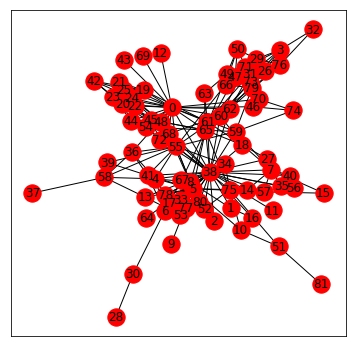

In [6]:
# drawing network for visualizing structure
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw_networkx(ys))

# Remove Links from Original Graph

In [7]:
# create an G_0 with an alpha percentage of edges from G
# create a list of the missing edges for link prediction for tau
import random

alpha = 0.90

random.seed(1)
missing = []
Go = nx.Graph()
Go.add_nodes_from(ys)
for e in ys.edges():
    if random.random() < alpha:
        Go.add_edges_from([e])
    else:
        missing.append(e)

# relabel nodes 0 to N for normalization
count = 0
mapping = {}
for n in Go.nodes():
    mapping[n] = count
    count+=1
Go = nx.relabel_nodes(Go, mapping)

# SBM Partitioning Functions

In [8]:
def tabulate_en(G,z,c):
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : ers, nrs

    ers = np.zeros([c,c])
    for i,j in G.edges():
        if(z[i] == z[j]):
            ers[z[i]][z[j]] += 1
        else:
            ers[z[i]][z[j]] += 1
            ers[z[j]][z[i]] += 1
    
    nrs = np.zeros([c,c])
    for n1 in G.nodes():
        for n2 in G.nodes():
            if (n1 != n2 and n2 > n1):
                if (z[n1] == z[n2]):
                    nrs[z[n1]][z[n2]] += 1
                else:
                    nrs[z[n1]][z[n2]] += 1
                    nrs[z[n2]][z[n1]] += 1
            
    return ers,nrs

In [9]:
def sbm_LogL(ers,nrs):
    # input  : ers is a c x c np.array of edge counts
    #        : nrs is a c x c np.array of possible edges 
    # output : the sbm log-likelihood
    
    c = ers.shape[1]  # number of groups
    logL = 0
    for r in range(c):
        for s in range(c):
            if (s >= r):
                if ers[r,s] < 1 or nrs[r,s] < 1:
                    temp = 0 # define 0^0 = 1
                else:
                    temp = (ers[r,s] * np.log(ers[r,s]/nrs[r,s])) + ((nrs[r,s] - ers[r,s]) * np.log((nrs[r,s] - ers[r,s])/nrs[r,s]))
                logL = logL + temp
    return logL

In [10]:
def plotLLsbm(LL,pc,n):
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)
    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [11]:
def makeAMovesbm(G,z,c,f):
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf
    for i in G.nodes():
        if f[i] == 0:
            s = int(z[i]) 
            for r in range(c): 
                z[i] = r 
                ers,nrs = tabulate_en(G,z,c)
                cur_logL = sbm_LogL(ers,nrs) 
                if (cur_logL > bestL):
                    bestL = cur_logL
                    bestMove = [i,r]
            z[i] = s
    return bestL,bestMove

In [12]:
def run_OnePhasesbm(G,z0,c):
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy
    n    = G.order()
    LL   = []
    halt = 0
    ers,nrs = tabulate_en(G,z0,c)
    L0      = sbm_LogL(ers,nrs)
    LL.append(L0)
    f     = dict.fromkeys(range(n), 0)
    t     = 0
    Lstar = L0
    zstar = copy.deepcopy(z0)
    tstar = t
    zt = copy.deepcopy(z0)
    for j in range(n):
        bestL, bestMove = makeAMovesbm(G,zt,c,f) 
        node = bestMove[0]
        label = bestMove[1]
        LL.append(bestL)
        f[node] = 1
        zt[node] = label
        if (bestL > Lstar):
            Lstar = bestL
            zstar = copy.deepcopy(zt)
        if (zstar == z0):
            halt = 1
    return zstar,Lstar,LL,halt

In [13]:
def fit_SBM(G,c,T,flag):
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy
    n  = G.order()
    LL   = []
    halt = 0
    zt      = random_z(n,c)
    ers,nrs = tabulate_en(G,zt,c)
    Lt      = sbm_LogL(ers,nrs)
    pc = 0
    while not halt:
        if (flag == 1):
            print(f'phase[{pc}] z[0], logL = {Lt}')
            drawGz(G,zt)
        zstar,Lstar,cur_LLs,halt = run_OnePhasesbm(G,zt,c)
        zt = copy.deepcopy(zstar)
        for num in cur_LLs:
            LL.append(num)
        pc += 1
        if (pc > T):
            halt = 1
    if (flag == 1):
        print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [14]:
def fit_SBM_reps(G,c,T,reps):
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    #        : reps, the number of times to run SBM
    # output : best_LL, maximum log-likelihood score
    #        : best_z, optimal partition
    
    best_LL = -np.inf
    for i in range(reps):
        zstar,Lstar,LL,pc = fit_SBM(G,c,T,0)
        if (max(LL) > best_LL):
            best_LL = max(LL)
            best_z = copy.deepcopy(zstar)
    return best_LL, best_z

# Apply SBM

In [15]:
# run the previous function and create a list of the top nreps LLs and partitions

LLs_sbm = []
zs_sbm = []
nreps = 30
for i in range(nreps):
    print("ON REP:", i)
    LLsbm, z_sbm = fit_SBM_reps(Go,2,5,5)
    LLs_sbm.append(LLsbm)
    zs_sbm.append(z_sbm)

ON REP: 0


KeyboardInterrupt: 

# DC-SBM Partitioning Functions

In [ ]:
def tabulate_wk(G,z,c):
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr

    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r
    for i,j in G.edges():
        if (z[i] == z[j]):
            wrs[z[i]][z[j]] += 2
            kpr[z[i]] += 2
        else:
            wrs[z[i]][z[j]] += 1
            wrs[z[j]][z[i]] += 1
            kpr[z[i]] += 1
            kpr[z[j]] += 1
    return wrs,kpr

In [ ]:
def dcsbm_LogL(wrs,kpr):
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    
    c = wrs.shape[1]  # number of groups
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    return logL

In [ ]:
def plotLL(LL,pc,n):
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)
    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [ ]:
def makeAMove(G,z,c,f):
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf
    for i in G.nodes():
        if f[i] == 0:
            s = int(z[i]) 
            for r in range(c): 
                z[i] = r 
                wrs,kpr = tabulate_wk(G,z,c)
                cur_logL = dcsbm_LogL(wrs,kpr) 
                if (cur_logL > bestL):
                    bestL = cur_logL
                    bestMove = [i,r]
            z[i] = s
    return bestL,bestMove

In [ ]:
def run_OnePhase(G,z0,c):
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy
    n    = G.order()
    LL   = []
    halt = 0
    wrs,kpr = tabulate_wk(G,z0,c)
    L0      = dcsbm_LogL(wrs,kpr)
    LL.append(L0)
    f     = dict.fromkeys(range(n), 0)
    t     = 0
    Lstar = L0
    zstar = copy.deepcopy(z0)
    tstar = t
    zt = copy.deepcopy(z0)
    for j in range(n):
        bestL, bestMove = makeAMove(G,zt,c,f) 
        node = bestMove[0]
        label = bestMove[1]
        LL.append(bestL)
        f[node] = 1
        zt[node] = label
        if (bestL > Lstar):
            Lstar = bestL
            zstar = copy.deepcopy(zt)
        if (zstar == z0):
            halt = 1
    return zstar,Lstar,LL,halt

In [ ]:
def fit_DCSBM(G,c,T,flag):
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy
    n  = G.order()
    LL   = []
    halt = 0
    zt      = random_z(n,c)
    wrs,kpr = tabulate_wk(G,zt,c)
    Lt      = dcsbm_LogL(wrs,kpr)
    pc = 0
    while not halt:
        if (flag == 1):
            print(f'phase[{pc}] z[0], logL = {Lt}')
            drawGz(G,zt)
        zstar,Lstar,cur_LLs,halt = run_OnePhase(G,zt,c)
        zt = copy.deepcopy(zstar)
        for num in cur_LLs:
            LL.append(num)
        pc += 1
        if (pc > T):
            halt = 1
    if (flag == 1):
        print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [ ]:
def fit_DCSBM_reps(G,c,T,reps):
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    #        : reps, the number of times to run DC-SBM
    # output : best_LL, maximum log-likelihood score
    #        : best_z, optimal partition
    
    best_LL = -np.inf
    for i in range(reps):
        zstar,Lstar,LL,pc = fit_DCSBM(G,c,T,0)
        if (max(LL) > best_LL):
            best_LL = max(LL)
            best_z = copy.deepcopy(zstar)
    return best_LL, best_z

# Apply DC-SBM

In [ ]:
# run the previous function and create a list of the top nreps LLs and partitions

LLs_dcsbm = []
zs_dcsbm = []

for i in range(nreps):
    print("ON REP:", i+1)
    LLdcsbm, z_dcsbm = fit_DCSBM_reps(Go,2,5,5)
    LLs_dcsbm.append(LLdcsbm)
    zs_dcsbm.append(z_dcsbm)

# Apply Random Partitioning

In [ ]:
# created nreps random partitions for baseline
zs_random = []
for i in range(nreps):
    zs_random.append(random_z(Go.order(), 2))

# Prediction Functions

In [ ]:
def predictor_Jaccard(Gx,i,j):
    # implements the Jaccard coefficient link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = Jaccard(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    num = 0
    for i_n in Gx.neighbors(i):               # go through i and j neighbors
        for j_n in Gx.neighbors(j):
            if (i_n == j_n):                  # if they're not the same node, they are a mutual edge, so increase num
                num += 1

    den = Gx.degree(i) + Gx.degree(j) - num
    uniform = np.random.uniform(0,(1 / (2*Gx.number_of_edges()))) # uniform random number from 0 to epsilon which is 1/2m
    score = (num / den) + uniform # create score and return
    return(score)

In [ ]:
def predictor_DegreeProd(Gx,i,j):
    # implements the baseline link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = DegreeProduct(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    di = Gx.degree[i]
    dj = Gx.degree[j]
    uniform = np.random.uniform(0,(1 / (2*Gx.number_of_edges())))
    score = (di * dj) + uniform
    return(score)

In [ ]:
def predictor_Baseline():
    # implements the baseline link predictor
    # input : none, because its output is independent of G
    # output: score(i,j) = r where r = Uniform(0,1)

    return np.random.uniform(0,1)

In [ ]:
def predictor_matrix(G, i, j, mm, z):
    # input  : G, a graph
    #        : i,j, a pair of nodes
    #        : mm, a proportional mixing matrix
    #        : z, a partition
    # output : score(i,j) = mm[z[i]][z[j]] + Uniform(0,epsilon)
    
    epsilon = 1 / (2 * len(G.edges()))
    return mm[z[i]][z[j]] + np.random.uniform(0, epsilon)

In [ ]:
def apply_Predictors(G,Y,mm,z):
    # input : G, a networkx simple graph
    #         Y, list of missing links in G
    # output: S, table of the form [ i | j | tau | baseline | matrix | jaccard | degree product ]

    X = []
    for i in G.nodes():
        for j in G.nodes():
            if(i != j and not G.has_edge(i,j)):
                if((i,j) not in X and (j,i) not in X):
                    X.append((i,j))
    
    S = [[0 for i in range(7)] for j in range(len(X))]
    row_ind = 0
    
    for i,j in X:
        S[row_ind][0] = i
        S[row_ind][1] = j
        if((i,j) in Y):
            S[row_ind][2] = 1
        else:
            S[row_ind][2]= 0   
            
        S[row_ind][3] = np.round(predictor_Baseline(),3)
        S[row_ind][4] = np.round(predictor_matrix(G, i, j, mm, z),3)
        S[row_ind][5] = np.round(predictor_Jaccard(G,i,j),3)
        S[row_ind][6] = np.round(predictor_DegreeProd(G,i,j),3)
        row_ind+=1
        
    return S

In [ ]:
def tabulate_TPR_FPR(S):
    # see Lecture Notes 4
    # input : a data structure S containing a table whose rows have the form:
    #         [ i j tau score(i,j) ]
    #        sorted in descending order of score(i,j)
    # output: a data structure T containing a table whose rows have the form:
    #         [ i j tau TPR FPR score(i,j) ]
    #        sorted descending in score(i,j)

    S = sorted(S, key=lambda x: x[3], reverse=True)
    T = [[0 for i in range(5)] for j in range(len(S))]
    tot_tp = 0
    for r in S:
        if(r[2] == 1):
            tot_tp += 1
    tot_fpr = len(S) - tot_tp
    fpr = 0
    tpr = 0
    row_ind = 0
    for r in S:
        T[row_ind][0] = r[0]
        T[row_ind][1] = r[1]
        T[row_ind][2] = r[2]
        if(r[2] == 1):
            tpr+=1
        T[row_ind][3] = tpr/tot_tp
        if(r[2] == 0):
            fpr+=1
        T[row_ind][4] = np.round(fpr/tot_fpr, 3)
        row_ind+=1
    return T

In [ ]:
def calculate_AUC(TPR,FPR):
    # see Lecture Notes 4
    # input : the TPR and FPR columns of your table (which have equal length and where TPR[0]=FPR[0]=0)
    # output: the AUC, a scalar on the unit interval

    auc = 0
    for i in range(1, len(TPR)):
        auc += TPR[i] * (FPR[i] - FPR[i-1])
    return np.round(auc, 2)

In [ ]:
def AUC_Helper(S):
    # input  : S, a table of i,j pairs and their predictor scores
    # output : AUC scores, true positive and false positive rates for each predictor algorithm
    
    arr = np.array(S)
    baseline = np.delete(arr, [4,5,6], axis=1)
    matrix = np.delete(arr, [3,5,6], axis=1)
    jaccard = np.delete(arr, [3,4,6], axis=1)
    degprod = np.delete(arr, [3,4,5], axis=1)
    
    T_base = tabulate_TPR_FPR(baseline)
    tpr_b = np.array(T_base)[:,3]
    fpr_b = np.array(T_base)[:,4]
    tpr_b = np.insert(tpr_b, 0, 0, axis = 0)
    fpr_b = np.insert(fpr_b, 0, 0, axis = 0)
    auc_b = calculate_AUC(tpr_b, fpr_b)


    T_matrix = tabulate_TPR_FPR(matrix)
    tpr_m = np.array(T_matrix)[:,3]
    fpr_m = np.array(T_matrix)[:,4]
    tpr_m = np.insert(tpr_m, 0, 0, axis = 0)
    fpr_m = np.insert(fpr_m, 0, 0, axis = 0)
    auc_m = calculate_AUC(tpr_m, fpr_m)
    
    
    T_jaccard = tabulate_TPR_FPR(jaccard)
    tpr_j = np.array(T_jaccard)[:,3]
    fpr_j = np.array(T_jaccard)[:,4]
    tpr_j = np.insert(tpr_j, 0, 0, axis = 0)
    fpr_j = np.insert(fpr_j, 0, 0, axis = 0)
    auc_j = calculate_AUC(tpr_j, fpr_j)

    
    T_degprod = tabulate_TPR_FPR(degprod)
    tpr_d = np.array(T_degprod)[:,3]
    fpr_d = np.array(T_degprod)[:,4]
    tpr_d = np.insert(tpr_d, 0, 0, axis = 0)
    fpr_d = np.insert(fpr_d, 0, 0, axis = 0)
    auc_d = calculate_AUC(tpr_d, fpr_d)


    return (auc_b, auc_m, auc_j, auc_d, fpr_b, tpr_b, fpr_m, tpr_m, fpr_j, tpr_j, fpr_d, tpr_d)

# Link Prediction - SBM

In [ ]:
# creates proportional mixing matrices for each optimal partition

mms_sbm = []
for z_sbm in zs_sbm:
    mm_sbm = np.zeros((2,2))
    for g1,g2 in Go.edges():
        if (z_sbm[g1] == z_sbm[g2]):
            mm_sbm[z_sbm[g1]][z_sbm[g2]] +=1 
        elif (z_sbm[g1] != z_sbm[g2]):
            mm_sbm[z_sbm[g1]][z_sbm[g2]] +=1 
            mm_sbm[z_sbm[g2]][z_sbm[g1]] +=1 
    mm_sbm = mm_sbm/len(Go.edges())
    mms_sbm.append(mm_sbm)
plt.matshow(mms_sbm[0])
plt.show()

In [ ]:
# applies each predictor on optimal SBM partitions and respective mixing matrices

aucs_sbm = []
for mm_sbm, z_sbm in zip(mms_sbm, zs_sbm):
    S_sbm = apply_Predictors(Go, missing, mm_sbm, z_sbm)

    S_sbm = sorted(S_sbm, key=lambda x: x[4], reverse=True)
    
    auc_b_sbm, auc_m_sbm, auc_j_sbm, auc_d_sbm, fpr_b_sbm, tpr_b_sbm, fpr_m_sbm, tpr_m_sbm, fpr_j_sbm, tpr_j_sbm, fpr_d_sbm, tpr_d_sbm = AUC_Helper(S_sbm)
    aucs_sbm.append([float(auc_b_sbm), float(auc_m_sbm), float(auc_j_sbm), float(auc_d_sbm)])


# Link Prediction - DC-SBM

In [ ]:
# creates proportional mixing matrices for each optimal partition

mms_dcsbm = []
for z_dcsbm in zs_dcsbm:
    mm_dcsbm = np.zeros((2,2))
    for g1,g2 in Go.edges():
        if (z_dcsbm[g1] == z_dcsbm[g2]):
            mm_dcsbm[z_dcsbm[g1]][z_dcsbm[g2]] +=1 
        elif (z_dcsbm[g1] != z_dcsbm[g2]):
            mm_dcsbm[z_dcsbm[g1]][z_dcsbm[g2]] +=1 
            mm_dcsbm[z_dcsbm[g2]][z_dcsbm[g1]] +=1 
    mm_dcsbm = mm_dcsbm/len(Go.edges())
    mms_dcsbm.append(mm_dcsbm)
plt.matshow(mms_dcsbm[0])
plt.show()

In [ ]:
# applies each predictor on optimal DC-SBM partitions and respective mixing matrices

aucs_dcsbm = []
for mm_dcsbm, z_dcsbm in zip(mms_dcsbm, zs_dcsbm):
    S_dcsbm = apply_Predictors(Go, missing, mm_dcsbm, z_dcsbm)

    S_dcsbm = sorted(S_dcsbm, key=lambda x: x[4], reverse=True)

    auc_b_dcsbm, auc_m_dcsbm, auc_j_dcsbm, auc_d_dcsbm, fpr_b_dcsbm, tpr_b_dcsbm, fpr_m_dcsbm, tpr_m_dcsbm, fpr_j_dcsbm, tpr_j_dcsbm, fpr_d_dcsbm, tpr_d_dcsbm = AUC_Helper(S_dcsbm)
    aucs_dcsbm.append([float(auc_b_dcsbm), float(auc_m_dcsbm), float(auc_j_dcsbm), float(auc_d_dcsbm)])


# Link Prediction - Random

In [ ]:
# creates proportional mixing matrices for each partition

mm_random = []
for Go_z in zs_random:
    mm_Go = np.zeros((2,2))
    for g1,g2 in Go.edges():
        if (Go_z[g1] == Go_z[g2]):
            mm_Go[Go_z[g1]][Go_z[g2]] +=1 
        elif (Go_z[g1] != Go_z[g2]):
            mm_Go[Go_z[g1]][Go_z[g2]] +=1 
            mm_Go[Go_z[g2]][Go_z[g1]] +=1 
    mm_Go =mm_Go/len(Go.edges())
    mm_random.append(mm_Go)

In [ ]:
# applies each predictor on random partitions and respective mixing matrices

aucs_random = []
for mm_Go, Go_z in zip(mm_random, zs_random):
    S_Go = apply_Predictors(Go, missing, mm_Go, Go_z)

    S_Go = sorted(S_Go, key=lambda x: x[4], reverse=True)

    auc_b_Go, auc_m_Go, auc_j_Go, auc_d_Go, fpr_b_Go, tpr_b_Go, fpr_m_Go, tpr_m_Go, fpr_j_Go, tpr_j_Go, fpr_d_Go, tpr_d_Go = AUC_Helper(S_Go)
    aucs_random.append([float(auc_b_Go), float(auc_m_Go), float(auc_j_Go), float(auc_d_Go)])

# AUC Plotting

In [ ]:
#SBM
baseline_sbm = []
matrix_sbm = []
jaccard_sbm = []
degprod_sbm = []
# separating auc scores by link prediction algorithm
for pair in aucs_sbm:
    baseline_sbm.append(pair[0])
    matrix_sbm.append(pair[1])
    jaccard_sbm.append(pair[2])
    degprod_sbm.append(pair[3])
ys = [i for i in range(1, nreps+1)] # creating x values for number of reps
# calculating means for each algorithm
mean_sbm_m = np.mean(matrix_sbm)
mean_sbm_b = np.mean(baseline_sbm)
mean_sbm_j = np.mean(jaccard_sbm)
mean_sbm_d = np.mean(degprod_sbm)
mean_sm = []
mean_sb = []
mean_sj = []
mean_sd = []
# creates y values for mean to generate straight line through trend
for i in range(nreps):
    mean_sm.append(mean_sbm_m)
    mean_sb.append(mean_sbm_b)
    mean_sj.append(mean_sbm_j)
    mean_sd.append(mean_sbm_d)

# DC-SBM - same concept as SBM
baseline_dcsbm = []
matrix_dcsbm = []
jaccard_dcsbm = []
degprod_dcsbm = []
for pair in aucs_dcsbm:
    baseline_dcsbm.append(pair[0])
    matrix_dcsbm.append(pair[1])
    jaccard_dcsbm.append(pair[2])
    degprod_dcsbm.append(pair[3])
mean_dcsbm_b = np.mean(baseline_dcsbm)
mean_dcsbm_m = np.mean(matrix_dcsbm)
mean_dcsbm_j = np.mean(jaccard_dcsbm)
mean_dcsbm_d = np.mean(degprod_dcsbm)
mean_db = []
mean_dm = []
mean_dj = []
mean_dd = []
for i in range(nreps):
    mean_db.append(mean_dcsbm_b)
    mean_dm.append(mean_dcsbm_m)
    mean_dj.append(mean_dcsbm_j)
    mean_dd.append(mean_dcsbm_d)
    
# Random - same concept as SBM
baseline_random = []
matrix_random = []
jaccard_random = []
degprod_random = []
for pair in aucs_random:
    baseline_random.append(pair[0])
    matrix_random.append(pair[1])
    jaccard_random.append(pair[2])
    degprod_random.append(pair[3])
mean_random_b = np.mean(baseline_random)
mean_random_m = np.mean(matrix_random)
mean_random_j = np.mean(jaccard_random)
mean_random_d = np.mean(degprod_random)
mean_rb = []
mean_rm = []
mean_rj = []
mean_rd = []
for i in range(nreps):
    mean_rb.append(mean_random_b)
    mean_rm.append(mean_random_m)
    mean_rj.append(mean_random_j)
    mean_rd.append(mean_random_d)


#Plots
# SBM - baseline, mixing matrix (SBM), jaccard and means
plt.figure(figsize=(20,10))
plt.ylabel("AUC Score", fontsize='xx-large')
plt.xlabel("Repetition", fontsize='xx-large')
plt.title("AUC scores for SBM", fontsize='xx-large')
plt.ylim(0.3, 0.9)
plt.plot(ys, mean_sb, '--', color = 'black')
plt.plot(ys, baseline_sbm, label = "Baseline AUC Scores", color = 'black', marker='*')
plt.plot(ys, mean_sm, '--', color = 'blue')
plt.plot(ys, matrix_sbm, label = "Mixing Matrix AUC Scores", color = 'blue', marker='*')
plt.plot(ys, mean_sj, '--', color = 'green')
plt.plot(ys, jaccard_sbm, label = "Jaccard AUC Scores", color = 'green', marker='*')
# plt.plot(ys, mean_sd, '--', color = 'red')
# plt.plot(ys, degprod_sbm, label = "Degree Product AUC Scores", color = 'red', marker='*')
plt.legend(bbox_to_anchor=(0.5,-0.2), loc='lower center', fontsize='xx-large', shadow=True, ncol=2)
plt.savefig("SBM.jpg")
plt.show()

# DCSBM - baseline, mixing matrix (DC-SBM), jaccard and means
plt.figure(figsize=(20,10))
plt.ylabel("AUC Score", fontsize='xx-large')
plt.xlabel("Repetition", fontsize='xx-large')
plt.title("AUC scores for DC-SBM", fontsize='xx-large')
plt.ylim(0.3, 0.9)
plt.plot(ys, mean_db, '--', color = 'black')
plt.plot(ys, baseline_dcsbm, label = "Baseline AUC Scores", color = 'black', marker='*')
plt.plot(ys, mean_dm, '--', color = 'blue')
plt.plot(ys, matrix_dcsbm, label = "Mixing Matrix AUC Scores", color = 'blue', marker='*')
plt.plot(ys, mean_dj, '--', color = 'green')
plt.plot(ys, jaccard_dcsbm, label = "Jaccard AUC Scores", color = 'green', marker='*')
# plt.plot(ys, mean_dd, '--', color = 'red')
# plt.plot(ys, degprod_dcsbm, label = "Degree Product AUC Scores", color = 'red', marker='*')
plt.legend(bbox_to_anchor=(0.5,-0.2), loc='lower center', fontsize='xx-large', shadow=True, ncol=2)
plt.savefig("DCSBM.jpg")

plt.show()

# Random - baseline, mixing matrix (random), jaccard and means
plt.figure(figsize=(20,10))
plt.ylabel("AUC Score", fontsize='xx-large')
plt.xlabel("Repetition", fontsize='xx-large')
plt.title("AUC scores for Random", fontsize='xx-large')
plt.ylim(0.3, 0.9)
plt.plot(ys, mean_rb, '--', color = 'black')
plt.plot(ys, baseline_random, label = "Baseline AUC Scores", color = 'black', marker='*')
plt.plot(ys, mean_rm, '--', color = 'blue')
plt.plot(ys, matrix_random, label = "Mixing Matrix AUC Scores", color = 'blue', marker='*')
plt.plot(ys, mean_rj, '--', color = 'green')
plt.plot(ys, jaccard_random, label = "Jaccard AUC Scores", color = 'green', marker='*')
# plt.plot(ys, mean_rd, '--', color = 'red')
# plt.plot(ys, degprod_random, label = "Degree Product AUC Scores", color = 'red', marker='*')
plt.legend(bbox_to_anchor=(0.5,-0.2), loc='lower center', fontsize='xx-large', shadow=True, ncol=2)
plt.savefig("RANDOM.jpg")
plt.show()

# All - baseline, mixing matrix (SBM, DC-SBM, random), jaccard and means
plt.figure(figsize=(20,10))
plt.ylabel("AUC Score", fontsize='xx-large')
plt.xlabel("Repetition", fontsize='xx-large')
plt.title("AUC scores for All", fontsize='xx-large')
plt.ylim(0.3, 0.9)
plt.plot(ys, mean_sb, '--', color = 'black')
plt.plot(ys, baseline_sbm, label = "Baseline AUC Scores", color = 'black', marker='*')
plt.plot(ys, mean_sm, '--', color = 'blue')
plt.plot(ys, matrix_sbm, label = "Mixing Matrix AUC Scores (SBM)", color = 'blue', marker='*')
plt.plot(ys, mean_dm, '--', color = 'red')
plt.plot(ys, matrix_dcsbm, label = "Mixing Matrix AUC Scores (DC-SBM)", color = 'red', marker='*')
plt.plot(ys, mean_rm, '--', color = 'purple')
plt.plot(ys, matrix_random, label = "Mixing Matrix AUC Scores (Random)", color = 'purple', marker='*')
plt.plot(ys, mean_sj, '--', color = 'green')
plt.plot(ys, jaccard_sbm, label = "Jaccard AUC Scores", color = 'green', marker='*')
plt.legend(bbox_to_anchor=(0.5,-0.2), loc='lower center', fontsize='xx-large', shadow=True, ncol=2)
plt.savefig("RANDOM.jpg")
plt.show()

# partitions - mixing matrix (SBM, DC-SBM, random)
plt.figure(figsize=(20,10))
plt.ylabel("AUC Score", fontsize='xx-large')
plt.xlabel("Repetition", fontsize='xx-large')
plt.title("AUC scores for Partitions", fontsize='xx-large')
plt.ylim(0.3, 0.9)
plt.plot(ys, mean_sm, '--', color = 'blue')
plt.plot(ys, matrix_sbm, label = "Mixing Matrix AUC Scores (SBM)", color = 'blue', marker='*')
plt.plot(ys, mean_dm, '--', color = 'red')
plt.plot(ys, matrix_dcsbm, label = "Mixing Matrix AUC Scores (DC-SBM)", color = 'red', marker='*')
plt.plot(ys, mean_rm, '--', color = 'purple')
plt.plot(ys, matrix_random, label = "Mixing Matrix AUC Scores (Random)", color = 'purple', marker='*')
plt.legend(bbox_to_anchor=(0.5,-0.2), loc='lower center', fontsize='xx-large', shadow=True, ncol=2)
plt.savefig("RANDOM.jpg")
plt.show()

# print means and standard deviations
import statistics as st

print("***********Means*************")
print()
print("SBM:")
print()
print("Baseline: ", mean_sbm_b)
print("Matrix: ", mean_sbm_m)
print("Jaccard: ", mean_sbm_j)
# print("Degree Product: ", mean_sbm_d)
print()
print("DCSBM:")
print()
print("Baseline: ", mean_dcsbm_b)
print("Matrix: ", mean_dcsbm_m)
print("Jaccard: ", mean_dcsbm_j)
# print("Degree Product: ", mean_dcsbm_d)
print()
print("Random:")
print()
print("Baseline: ", mean_random_b)
print("Matrix: ", mean_random_m)
print("Jaccard: ", mean_random_j)
# print("Degree Product: ", mean_random_d)

print('\n\n\n')

print("*****Standard Deviations*****")
print()
print("SBM:")
print()
print("Stdev Baseline: ", st.stdev(baseline_sbm))
print("Stdev Matrix: ", st.stdev(matrix_sbm))
print("Stdev Jaccard: ", st.stdev(jaccard_sbm))
# print("Stdev Degree Product: ", st.stdev(degprod_sbm))
print()
print("DC-SBM:")
print()
print("Stdev Baseline: ", st.stdev(baseline_dcsbm))
print("Stdev Matrix: ", st.stdev(matrix_dcsbm))
print("Stdev Jaccard: ", st.stdev(jaccard_dcsbm))
# print("Stdev Degree Product: ", st.stdev(degprod_dcsbm))
print()
print("Random:")
print()
print("Stdev Baseline: ", st.stdev(baseline_random))
print("Stdev Matrix: ", st.stdev(matrix_random))
print("Stdev Jaccard: ", st.stdev(jaccard_random))
# print("Stdev Degree Product: ", st.stdev(degprod_random))